<a href="https://colab.research.google.com/github/SharonEstivalez/FisicaComputacional1/blob/master/Evaluaci%C3%B3n%201/Evaluaci%C3%B3n1_Sharon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***$$EVALUACIÓN  \space 1$$***



Pacheco Rodriguez Sharon Estivalez

 24/ 02/ 21

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Bibliotecas para el análisis de series de tiempo y modelos de pronóstico
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import acf, pacf

import pandas.util.testing as tm

#Suprimir mensajes de alertas de cambios futuros
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Matplotlib mostrará los resultados en la Notebook de Jupyter
%matplotlib inline

# **Parte 1. Construcción de una Serie de Tiempo**

In [ ]:
#Los archivos de datos contienen las observaciones promedio diarias. 
#Al principio de cada archivo indica cuantas líneas contiene el encabezado, 
#para considerarlo a la hora de leer el archivo CSV (aquí separado por espacios).

#Tomar la url en raw
url = 'https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Eval1/data/co2_spo_DailyData.txt'


#Nombres para las columnas
col =  ['site_code', 'year', 'month', 'day', 'hour', 'minute', 'second', 'time_decimal', 'value', 'value_std_dev', 'nvalue', 'latitude', 'longitude', 'altitude', 'elevation', 'intake_height', 'qcflag']

# encoding='cp1251' Windows (Europa Occidental)
# sep='\s+' el separador de datos es de uno o más espacios
#header=None no hay encabezado
#skiprows=151 Se brincará los primeros 151 renglones del encabezado
#engine='python' Se procesan los datos utilizando Python 
df_act = pd.read_csv(url, names=col, encoding='cp1251', sep='\s+', header=None, skiprows=151, engine='python')


In [ ]:
#Esto es para mí, quiero ver los datos antes de modificarlos
df_act.head()

,site_code,year,month,day,hour,minute,second,time_decimal,value,value_std_dev,nvalue,latitude,longitude,altitude,elevation,intake_height,qcflag
0,SPO,1975,1,1,0,0,0,1975.000000,-999.99,-99.99,0,-89.98,-24.8,2820.0,2810.0,10.0,*..
1,SPO,1975,1,2,0,0,0,1975.002740,-999.99,-99.99,0,-89.98,-24.8,2820.0,2810.0,10.0,*..
2,SPO,1975,1,3,0,0,0,1975.005479,-999.99,-99.99,0,-89.98,-24.8,2820.0,2810.0,10.0,*..
3,SPO,1975,1,4,0,0,0,1975.008219,-999.99,-99.99,0,-89.98,-24.8,2820.0,2810.0,10.0,*..
4,SPO,1975,1,5,0,0,0,1975.010959,-999.99,-99.99,0,-89.98,-24.8,2820.0,2810.0,10.0,*..


In [ ]:
#Nos interesa la columna de 'value' que corresponde a las concentraciones de CO2. Cuando hay datos faltantes, aparece el número -999.99. 
#Habrá que reemplazarlo por NaN. Las series de tiempo son de mediados de 1970 al 2019-12-31. 

#Reemplazar "-999.99" por NaN
Orig = -999.99
df_act1 = df_act.replace(to_replace= Orig, value= np.nan, regex=True)
df_act1.head()


,site_code,year,month,day,hour,minute,second,time_decimal,value,value_std_dev,nvalue,latitude,longitude,altitude,elevation,intake_height,qcflag
0,SPO,1975,1,1,0,0,0,1975.000000,NaN,-99.99,0,-89.98,-24.8,2820.0,2810.0,10.0,*..
1,SPO,1975,1,2,0,0,0,1975.002740,NaN,-99.99,0,-89.98,-24.8,2820.0,2810.0,10.0,*..
2,SPO,1975,1,3,0,0,0,1975.005479,NaN,-99.99,0,-89.98,-24.8,2820.0,2810.0,10.0,*..
3,SPO,1975,1,4,0,0,0,1975.008219,NaN,-99.99,0,-89.98,-24.8,2820.0,2810.0,10.0,*..
4,SPO,1975,1,5,0,0,0,1975.010959,NaN,-99.99,0,-89.98,-24.8,2820.0,2810.0,10.0,*..


In [ ]:
#Para construir una serie de tiempo que deseamos analizar, 
#se pide construir una columna de 'Fecha' variable de tipo datetime,  combinando las columnas 'year', 'month', y 'day'.  
df_act2 = df_act1.copy()
df_act2['Fecha'] = df_act2['year'].astype(str) + "-" + df_act2['month'].astype(str) + "-" + df_act2['day'].astype(str)

df_act2['Fecha'] = pd.to_datetime(df_act2['Fecha'], dayfirst=True)
df_act2.head() 

,site_code,year,month,day,hour,minute,second,time_decimal,value,value_std_dev,nvalue,latitude,longitude,altitude,elevation,intake_height,qcflag,Fecha
0,SPO,1975,1,1,0,0,0,1975.000000,NaN,-99.99,0,-89.98,-24.8,2820.0,2810.0,10.0,*..,1975-01-01
1,SPO,1975,1,2,0,0,0,1975.002740,NaN,-99.99,0,-89.98,-24.8,2820.0,2810.0,10.0,*..,1975-01-02
2,SPO,1975,1,3,0,0,0,1975.005479,NaN,-99.99,0,-89.98,-24.8,2820.0,2810.0,10.0,*..,1975-01-03
3,SPO,1975,1,4,0,0,0,1975.008219,NaN,-99.99,0,-89.98,-24.8,2820.0,2810.0,10.0,*..,1975-01-04
4,SPO,1975,1,5,0,0,0,1975.010959,NaN,-99.99,0,-89.98,-24.8,2820.0,2810.0,10.0,*..,1975-01-05


In [ ]:
#Después se pide construir un dataframe que contiene desde el inicio de 1980 hasta fin de 2019.
df_80 = df_act2[(df_act2['year'] >= 1980) & (df_act2['year'] <= 2019)]


In [ ]:
#Convierte el dataframe anterior a serie de tiempo 'ts_test', usando 'Fecha' como índice. 
ts_test = df_80.copy()

ts_test = ts_test.set_index('Fecha')

ts_test.head()

,site_code,year,month,day,hour,minute,second,time_decimal,value,value_std_dev,nvalue,latitude,longitude,altitude,elevation,intake_height,qcflag
Fecha,,,,,,,,,,,,,,,,,
1980-01-01,SPO,1980,1,1,0,0,0,1980.000000,336.30,0.08,17,-89.98,-24.8,2823.5,2810.0,13.5,...
1980-01-02,SPO,1980,1,2,0,0,0,1980.002732,336.28,0.08,24,-89.98,-24.8,2823.5,2810.0,13.5,...
1980-01-03,SPO,1980,1,3,0,0,0,1980.005464,336.21,0.11,24,-89.98,-24.8,2823.5,2810.0,13.5,...
1980-01-04,SPO,1980,1,4,0,0,0,1980.008197,336.19,0.08,22,-89.98,-24.8,2823.5,2810.0,13.5,...
1980-01-05,SPO,1980,1,5,0,0,0,1980.010929,336.20,0.09,16,-89.98,-24.8,2823.5,2810.0,13.5,...


In [ ]:
#La serie de tiempo de concentraciones de CO2, sólo deberá tener la Fecha como índice y la columna de CO2.  
ts_test = ts_test.drop(['site_code', 'year', 'month', 'day', 'hour', 'minute', 'second', 'time_decimal', 'value_std_dev', 'nvalue', 'latitude', 'longitude', 'altitude', 'elevation', 'intake_height', 'qcflag'], axis=1)


ts_test.head()


,value
Fecha,
1980-01-01,336.30
1980-01-02,336.28
1980-01-03,336.21
1980-01-04,336.19
1980-01-05,336.20


In [ ]:
#Puedes usar la función de Pandas ts_test.ffill(axis = 0, inplace=True), 
#para rellenar hacia enfrente los valores vacíos en base al último valor anterior disponible.  
ts_test.ffill(axis = 0, inplace=True)

# **Parte 2. Análisis de la Serie de Tiempo**

In [ ]:
#Define una función para probar estacionaridad utilizando la Prueba Avanzada de Dickey-Fuller: test_stationarity(df_ts)


#Función para probar la estacionaridad de una serie de tiempo: 'timeseries'
   
def test_stationarity(df_ts):
    
#Determinar la Estadística de promedios móviles
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std() #std Desviación estándar
    
#Define el tamaño de la figura
    plt.rcParams["figure.figsize"] = (12,6)

#Graficar la Estadística de promedios móviles 
    plt.plot(df_ts, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar')
    plt.grid()
    plt.show()
 
#Realiza la Prueba Aumentada de Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


In [ ]:
#Serie de tiempo a probar

#Fecha inicio: 1980-01, fin: 2019-12
start, end = '1980-01', '2019-12'

ts_test = ts_test.loc[start:end].copy()

#Definir serie de tiempo con value

ts_test1 = ts_test['value'].copy()


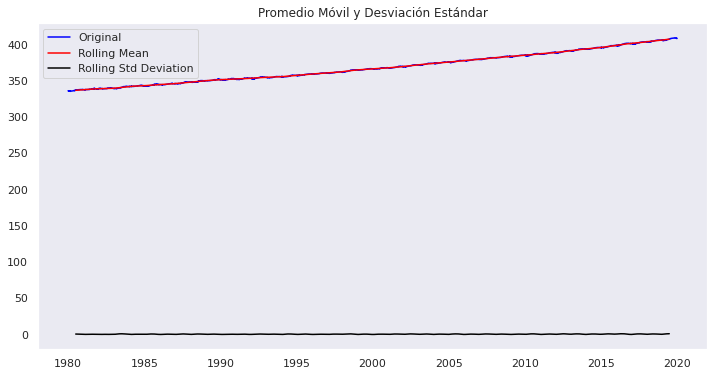

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                     0.973933
p-value                            0.993983
#Lags Used                        42.000000
Number of Observations Used    14567.000000
Critical Value (1%)               -3.430799
Critical Value (5%)               -2.861738
Critical Value (10%)              -2.566876
dtype: float64


In [ ]:
#Realizar la prueba de estacionaridad
test_stationarity(ts_test1)

*Prueba la estacionaridad de tu serie de tiempo 'ts_test' en base al valor p.*

La serie no es estacionaria ya que p>0.05. Se necesitan realizar transformaciones.

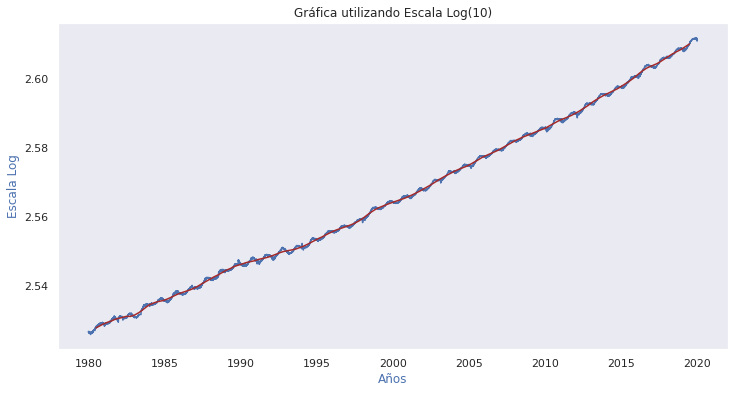

In [84]:
#Si no es una serie de tiempo estacionaria, cambia de escala a Log(CO2), y gráfica la nueva función. 

#Graficar en escala logaritmo base 10
ts_test1_log = np.log10(ts_test1)

moving_avg = ts_test1_log.rolling(365, center=True).mean()

plt.plot(ts_test1_log)
plt.plot(moving_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Gráfica utilizando Escala Log(10)')
plt.grid()
plt.show();


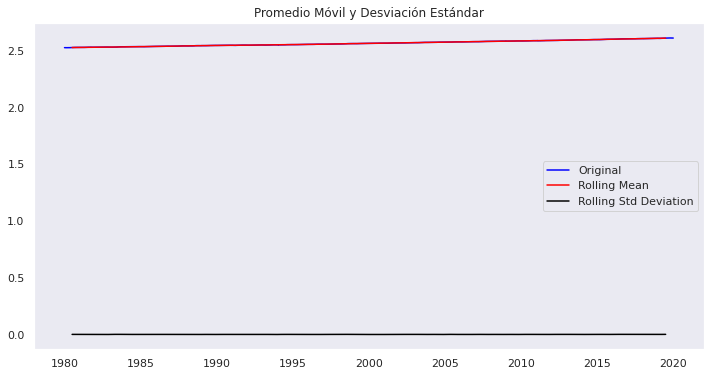

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                     0.538071
p-value                            0.985985
#Lags Used                        42.000000
Number of Observations Used    14567.000000
Critical Value (1%)               -3.430799
Critical Value (5%)               -2.861738
Critical Value (10%)              -2.566876
dtype: float64


In [85]:
test_stationarity(ts_test1_log)

Sigue sin ser estacionaria

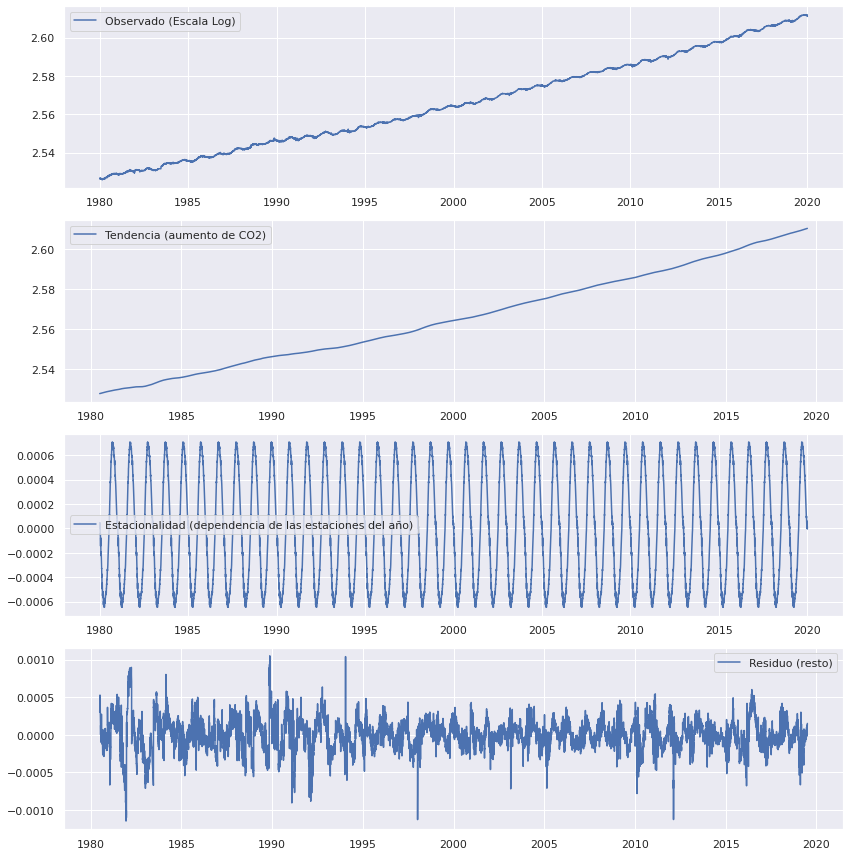

In [86]:
#Haz una descomposición estacional de la serie 'ts_test_log', usando interpolación, y promedio móvil de 365 días. 
#Produce las gráficas de las series que la componen. Comenta la serie de tendencia (aumento de CO2), 
#estacionalidad (dependencia de las estaciones del año) y residuo (el resto).  


#Tamaño

#sns.set(rc={'figure.figsize':(12, 12)})

#Periodo de datos completo 
#start, end = '1980-01', '2019-12'  #no lo necesito, ya se eligió el período al hacer la serie.

#Ciclo anual
decompfreq = 365 #se puede poner directo

des = sm.tsa.seasonal_decompose(ts_test1_log.interpolate(),
                                    freq=decompfreq, model='additive')
#des.plot()

trend = des.trend  #Tendencia
seasonal = des.seasonal  #Estacionalidad
residue = des.resid   #Residuo

#Gráficas
plt.rcParams["figure.figsize"] = (12,12)

plt.subplot(411)
plt.plot(ts_test1_log, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia (aumento de CO2)')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad (dependencia de las estaciones del año)')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo (resto)')
plt.legend(loc='best')

#Gráficas cerca
plt.tight_layout();


- Tendencia: se puede notar que el de aumento de CO2 es lineal y va aumentando conforme transcurre el tiempo, pero, considerando que la escala es logarítmica, simplemente se asume que incrementa muy rápidamente al paso del tiempo.
- Estacionalidad: Por la cantidad de años que abarca no se puede notar claramente.
- Residuo: Su variabilidad parece disminuir ligeramente.

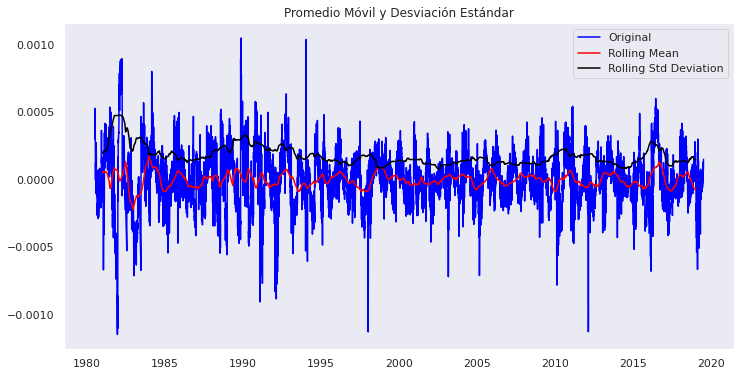

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.135572e+01
p-value                        9.746288e-21
#Lags Used                     2.800000e+01
Number of Observations Used    1.421700e+04
Critical Value (1%)           -3.430810e+00
Critical Value (5%)           -2.861743e+00
Critical Value (10%)          -2.566878e+00
dtype: float64


In [87]:
#Prueba la estacionaridad de la serie residuo.  
#Serie de tiempo a probar

ts_test1_log_des = residue
ts_test1_log_des.dropna(inplace=True)
test_stationarity(ts_test1_log_des)

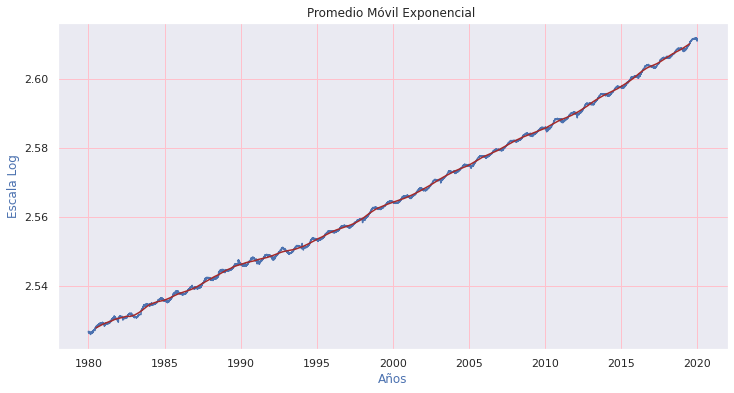

In [88]:
#Luego calcula un promedio móvil centrado sobre 'ts_test_log' usando un periodo de 365 días y 
#contrastarlo en una gráfica con la serie de Log CO2.


moving_avg = ts_test1_log.rolling(365, center=True).mean()

plt.plot(ts_test1_log)
plt.plot(moving_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Promedio Móvil Exponencial ')
plt.grid(color= 'pink')
plt.show();

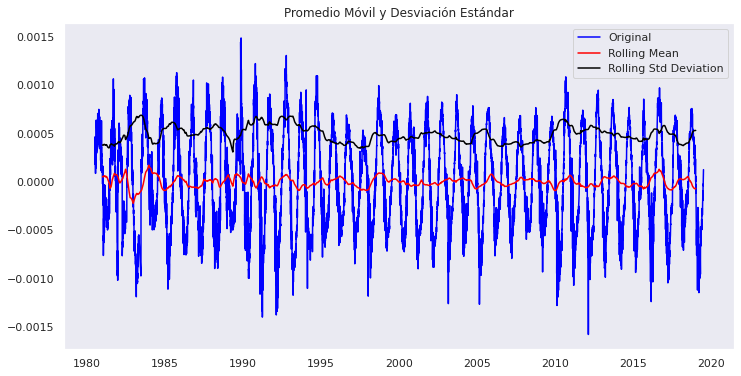

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.135538e+01
p-value                        9.763779e-21
#Lags Used                     4.200000e+01
Number of Observations Used    1.420300e+04
Critical Value (1%)           -3.430811e+00
Critical Value (5%)           -2.861744e+00
Critical Value (10%)          -2.566878e+00
dtype: float64


In [89]:
#Define un nuevo dataframe con la diferencia entre la serie logaritmo original y el promedio móvil, y prueba después su estacionaridad.
ts_test1_log_moving_ave_diff = ts_test1_log - moving_avg 
ts_test1_log_moving_ave_diff.dropna(inplace=True)
test_stationarity(ts_test1_log_moving_ave_diff)

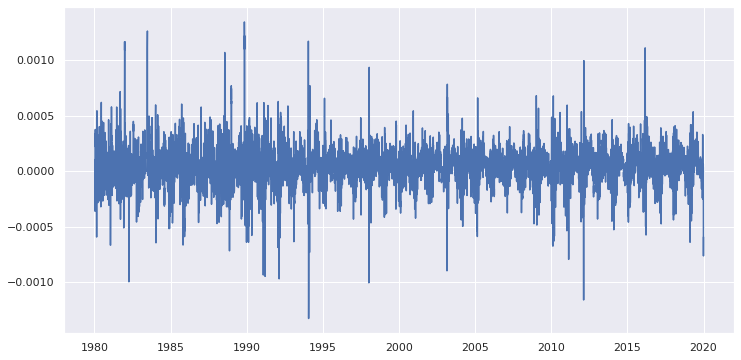

In [90]:
#Adicionalmente, prueba construir una serie estacionaria usando la función de diferenciación shift con un periodo de 7 días,
# que utiliza menos puntos que el promedio móvil.   

ts_test1_log_diff = ts_test1_log - ts_test1_log.shift(periods=7)
ts_test1_log_diff.dropna(inplace=True)
plt.plot(ts_test1_log_diff);

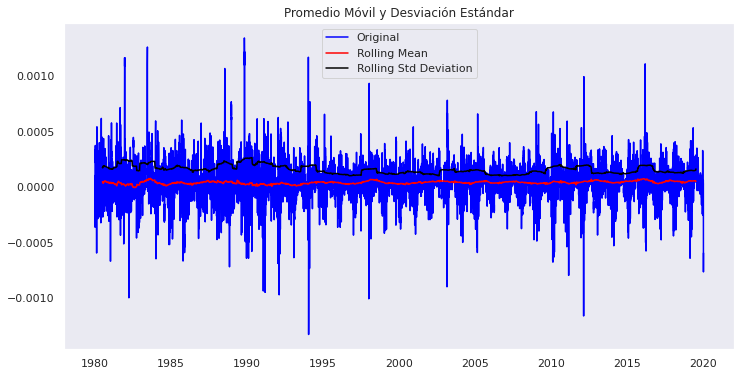

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.171651e+01
p-value                        1.446943e-21
#Lags Used                     4.200000e+01
Number of Observations Used    1.456000e+04
Critical Value (1%)           -3.430799e+00
Critical Value (5%)           -2.861739e+00
Critical Value (10%)          -2.566876e+00
dtype: float64


In [91]:
#Prueba la estacionaridad de esa última serie de tiempo 'ts_test_log_diff'.
test_stationarity(ts_test1_log_diff)

**ARIMA**

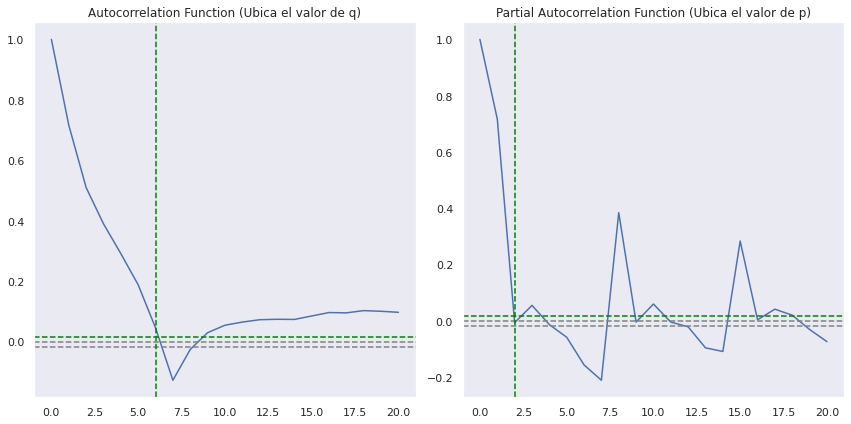

In [93]:
#Construye un modelo ARIMA de la serie 'ts_test_log_diff', calculando los parámetros p, q y utiliza d=1 (ya que hemos ya derivado una vez)  

# Aplicamos ARIMA

lag_acf = acf(ts_test1_log_diff, nlags=20)
lag_pacf = pacf(ts_test1_log_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test1_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test1_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=6, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test1_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test1_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

q=6 y p=2

**Modelo AR (Auto-Regresión)**

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                14609
Model:                 ARIMA(2, 1, 0)   Log Likelihood              116098.859
Method:                       css-mle   S.D. of innovations              0.000
Date:                Thu, 25 Feb 2021   AIC                        -232189.718
Time:                        04:15:09   BIC                        -232159.360
Sample:                    01-02-1980   HQIC                       -232179.632
                         - 12-31-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.788e-06   5.33e-07     10.851      0.000    4.74e-06    6.83e-06
ar.L1.D.value    -0.1522      0.008    -18.682      0.000      -0.168      -0.136
ar.L2.D.value    -0.1753      0.008    -

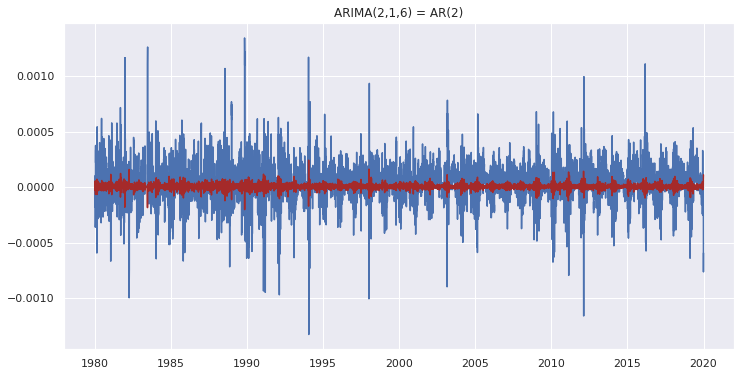

In [100]:
#Para seleccionar el mejor modelo, calcula el Criterio de Información de Akaike (AIC) de los modelos: AR(p), MA(q), y ARIMA (p,d,q). 

#Modelo AR(p): (p,d,q) = (2,1,6) 
model = ARIMA(ts_test1_log, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test1_log_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,6) = AR(2)')
print(results_AR.summary())


In [99]:
AIC_AR = -232189.718

**Modelo MA (Promedio Móvil)**

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                14609
Model:                 ARIMA(0, 1, 6)   Log Likelihood              115820.123
Method:                       css-mle   S.D. of innovations              0.000
Date:                Thu, 25 Feb 2021   AIC                        -231624.247
Time:                        04:16:46   BIC                        -231563.532
Sample:                    01-02-1980   HQIC                       -231604.076
                         - 12-31-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.815e-06   2.44e-07     23.850      0.000    5.34e-06    6.29e-06
ma.L1.D.value    -0.1786      0.009    -20.393      0.000      -0.196      -0.161
ma.L2.D.value    -0.2081      0.008    -

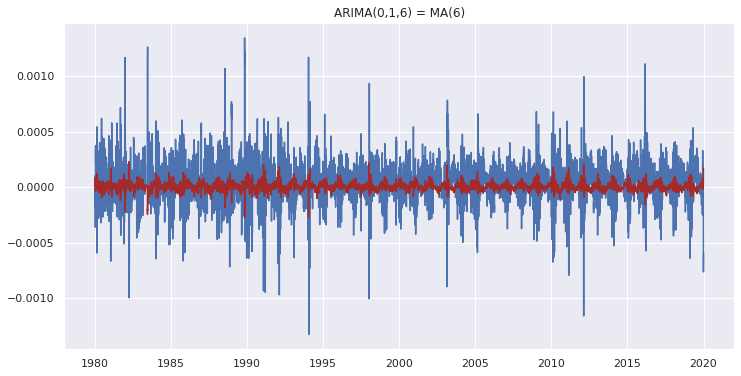

In [101]:
#Modelo MA(q): (p,d,q) = (2,1,6) 
model = ARIMA(ts_test1_log, order=(0,1,6), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test1_log_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,6) = MA(6)')
print(results_MA.summary())

In [103]:
AIC_MA = -231624.247

**Modelo ARIMA (Auto-Regresión + Promedio Móvil)**

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                14609
Model:                 ARIMA(2, 1, 6)   Log Likelihood              116209.927
Method:                       css-mle   S.D. of innovations              0.000
Date:                Thu, 25 Feb 2021   AIC                        -232399.855
Time:                        04:25:19   BIC                        -232323.961
Sample:                    01-02-1980   HQIC                       -232374.642
                         - 12-31-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.795e-06   4.18e-07     13.861      0.000    4.98e-06    6.61e-06
ar.L1.D.value     0.3648        nan        nan        nan         nan         nan
ar.L2.D.value    -0.6854      0.094     

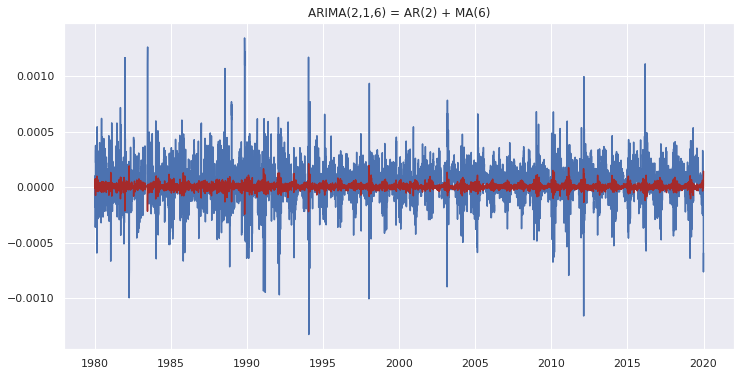

In [104]:
# Modelo ARIMA(p): (p,d,q) = (2,1,6) 
model = ARIMA(ts_test1_log, order=(2,1,6), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test1_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,6) = AR(2) + MA(6)')
print(results_ARIMA.summary())


In [111]:
AIC_AR_MA = -232399.855

print('AIC_AR:', AIC_AR)
print('AIC_MA:', AIC_MA)
print('AIC_AR_MA:', AIC_AR_MA)

print('EL MEJOR ES ARIMA(2,1,6)')

AIC_AR: -232189.718
AIC_MA: -231624.247
AIC_AR_MA: -232399.855
EL MEJOR ES ARIMA(2,1,6)


**Predicciones**

In [113]:
#Contrasta la serie observada de concentraciones de CO2 contra la construida por el modelo ARIMA.
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff)


Fecha
1980-01-02    0.000006
1980-01-03    0.000010
1980-01-04    0.000026
1980-01-05    0.000032
1980-01-06    0.000022
                ...   
2019-12-27    0.000004
2019-12-28    0.000018
2019-12-29    0.000034
2019-12-30    0.000087
2019-12-31    0.000142
Length: 14609, dtype: float64


In [116]:
#Sumar las predicciones de ARIMA a la serie observada (ts_test1_log)
predictions_ARIMA_log = pd.Series(ts_test1_log, index = ts_test1_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff)
print(predictions_ARIMA_log.head())

Fecha
1980-01-01         NaN
1980-01-02    2.526707
1980-01-03    2.526621
1980-01-04    2.526611
1980-01-05    2.526630
dtype: float64


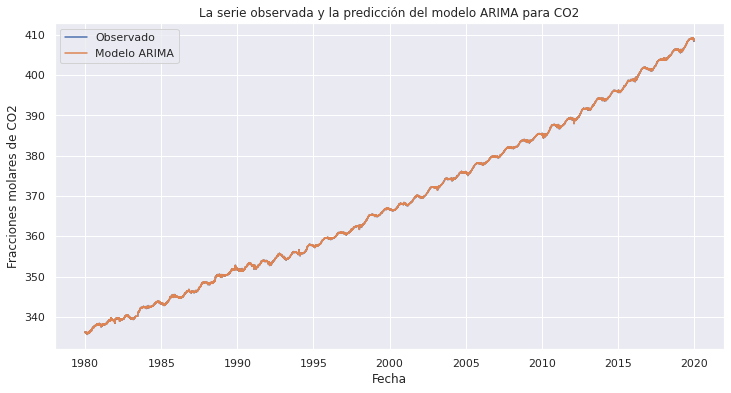

In [120]:
# Regresamos a la escala de Temperatura original
predictions_ARIMA = 10**(predictions_ARIMA_log)

# Graficamos la serie original y las predicciones con ARIMA
# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_test1, label='Observado');
plt.plot(predictions_ARIMA, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Fracciones molares de CO2')
plt.title('La serie observada y la predicción del modelo ARIMA para CO2')
plt.legend(loc='best');

In [121]:
#Calcula el error RMSE

#Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_test1)**2))
print('RMSE:', RMSE)

RMSE: 0.018899244271053547


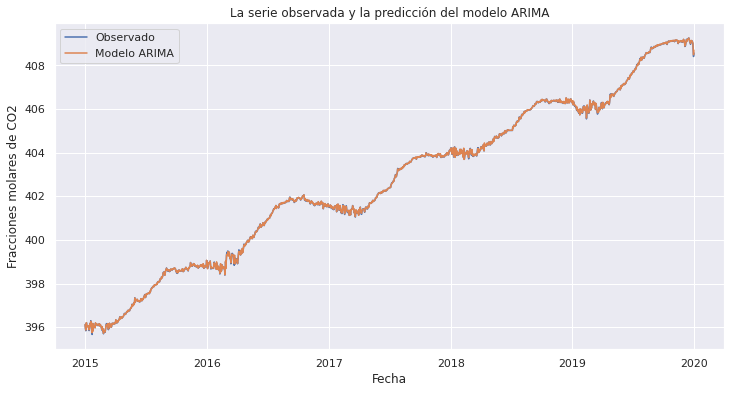

In [125]:
#Por último contrasta los 5 últimos años de la Serie de CO2 y el modelo ARIMA para ver mas a detalles el modelo.

start, end = '2015-01', '2019-12'
ts_test1_last = ts_test1.loc[start:end].copy()
predictions_ARIMA_last = predictions_ARIMA.loc[start:end].copy()


plt.plot(ts_test1_last, label='Observado');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Fracciones molares de CO2')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');
